## Import the libraries and load in the data

### Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import itertools
import os
from collections import defaultdict
import string
from functools import partial
from time import time
from typing import List, Tuple, Dict

import nltk
from tqdm import tqdm
import spacy

import xgboost as xgb
import lightgbm as lgb

from sklearn import model_selection, ensemble, linear_model, svm
from sklearn import metrics, manifold, decomposition, tree, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import base

import warnings
warnings.filterwarnings('ignore')

### Constants

In [2]:
SEED = 2406
TEST_SIZE = 0.15
VOCAB_SIZE = 2000

SHOULD_SAVE = False
SHOULD_DOWNLOAD = False

### Loading the data

## Forming the target class

In [4]:
qns = pd.read_csv("../datasets/CPTDS-3.csv")
qns.rename(columns={'tag1':'tag','stop_words_removed_qns':'qn'}, inplace=True)

In [5]:
qns["tag"].unique(), qns["tag"].nunique()

(array(['graph', 'array', 'string'], dtype=object), 3)

## Preprocessing

### Removing punctuations

In [6]:
print(f"Punctuation symbols: {string.punctuation}")

puncts = string.punctuation

idx_open = puncts.index('[')
puncts = puncts[:idx_open] + puncts[idx_open+1:]

idx_closed = puncts.index(']')
puncts = puncts[:idx_closed] + puncts[idx_closed+1:]

print(puncts)

Punctuation symbols: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@\^_`{|}~


In [7]:
qns

,qn,tag
0,Andrew love sea that s height summer season de...,graph
1,you give tree consist n vertex Initially verte...,graph
2,monocarp playing Minecraft want build wall cac...,graph
3,you give rooted tree consist n vertex the vert...,graph
4,you give n segment coordinate axis the ith seg...,array
...,...,...
3007,give integer array num positive integer return...,array
3008,you give 0indexed array num size n consist non...,array
3009,you give integer array num integer k find maxi...,array
3010,you give 0indexed integer array cost costsi co...,array


In [8]:
def remove_punctuation(text):
  new_text = "".join([t for t in text if t not in puncts])
  return new_text

qns['qn'] = qns['qn'].apply(lambda qn:remove_punctuation(qn))

### Lower casing the text

In [9]:
qns['qn'] = qns['qn'].str.lower()

### Stop word removal

In [10]:
if SHOULD_DOWNLOAD:
    nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
def remove_stopwords(text):
  new_text = [word for word in text.split(' ') if word not in stopwords]
  return ' '.join(new_text)

In [12]:
qns['qn'] = qns['qn'].apply(lambda qn: remove_stopwords(qn))

### Lemmatization

In [13]:
if SHOULD_DOWNLOAD:
    nltk.download('omw-1.4')
    nltk.download('wordnet')
wn_lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatizer(text):
  new_text = [wn_lemmatizer.lemmatize(word) for word in text.split(' ')]
  return ' '.join(new_text)

In [14]:
qns['qn'] = qns['qn'].apply(lambda qn: lemmatizer(qn))

In [15]:
len_of_qns = qns['qn'].str.split().apply(lambda qn: len(qn))

In [16]:
print(f"Mean length of a qn: {len_of_qns.mean()}")
print(f"Max length of a qn: {len_of_qns.max()}")
print(f"Min length of a qn: {len_of_qns.min()}")

Mean length of a qn: 87.66965471447543
Max length of a qn: 789
Min length of a qn: 8


Text(0.5, 1.0, 'Distribution of lengths')

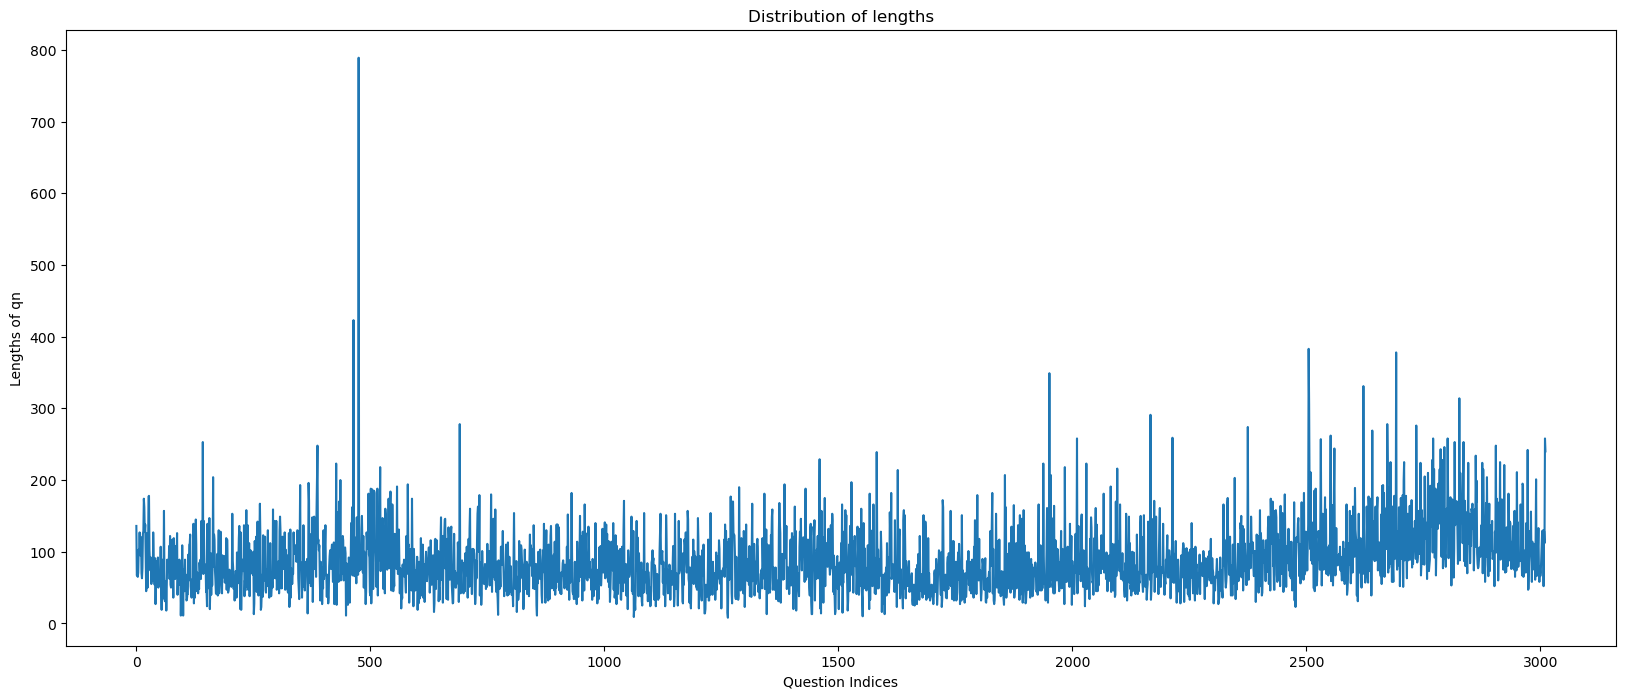

In [17]:
plt.figure(figsize=(20,8))
plt.plot(len_of_qns)
plt.xlabel('Question Indices')
plt.ylabel('Lengths of qn')
plt.title("Distribution of lengths")

We notice that the minimum length for a question is 2, which is definitely an outlier. <br>
Let's trim the dataset so that the minimum length is 15. 

In [18]:
less_than_15_idx = len_of_qns[len_of_qns<15].index
qns.drop(less_than_15_idx, inplace=True)

In [19]:
qns.reset_index(drop=True, inplace=True)

Let's look at the distribution again

Text(0.5, 1.0, 'Distribution of lengths')

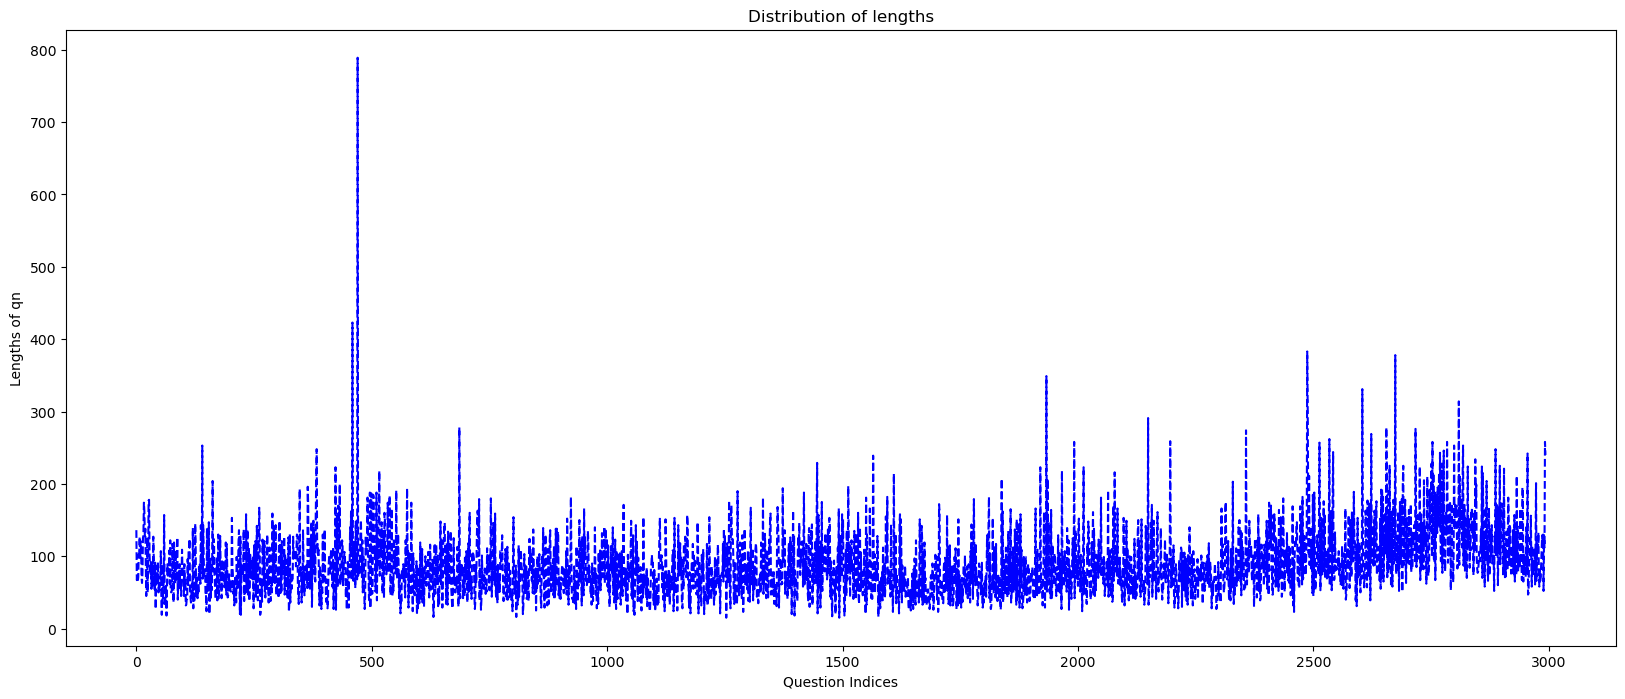

In [20]:
plt.figure(figsize=(20,8))
plt.plot(qns['qn'].str.split().apply(lambda qn: len(qn)), 'b--')
plt.xlabel('Question Indices')
plt.ylabel('Lengths of qn')
plt.title("Distribution of lengths")

## Modelling Process

Steps to be followed,
* `TfidfVectorizer` will be used to convert the text data into a vector representation
* `StratifiedKFold` with `k` being 10, will be used as the validation method as the distribution of classes is imbalanced
* `Tree-based ensemble models and logistic regression` will be used in their base forms without any hyperparameter tuning to find the best performing models
* `Random Search` will be used for finding the optimal parameter space and `Grid Search` will be used for finding the best parameters of the best performing model.
* Metrics that will be used for evaluation are `accuracy_score`, `precision`, `recall` and `f1-score`.

Text(0, 0.5, 'Count')

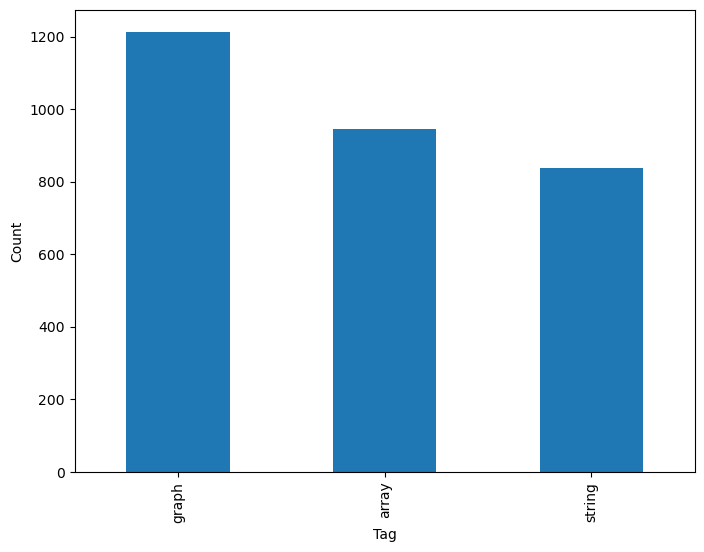

In [21]:
fig, ax = plt.subplots(1,1)
qns['tag'].value_counts().sort_values(ascending=False).plot.bar(figsize=(8,6),
                                                                ax=ax)
ax.set_xlabel('Tag')
ax.set_ylabel('Count')

In [22]:
classes = {key:value for value, key in enumerate(qns["tag"].unique())}
qns_sub = qns[qns["tag"].isin(classes.keys())]
qns_sub.reset_index(drop=True, inplace=True)

In [23]:
classes

{'graph': 0, 'array': 1, 'string': 2}

In [24]:
classes.keys()

dict_keys(['graph', 'array', 'string'])

### Creating training and test sets

In [25]:
qns_sub['tag'].unique()

array(['graph', 'array', 'string'], dtype=object)

In [26]:
qns_sub['tag'] = qns_sub['tag'].map(classes)

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(qns_sub['qn'], 
                                                                    qns_sub['tag'],
                                                                    test_size=TEST_SIZE,
                                                                    random_state=SEED,
                                                                    stratify=qns_sub['tag'])

In [28]:
y_train, y_test = y_train.values, y_test.values

### Vectorizing the text data

`TfidfVectorizer` from `scikit-learn` will be used initially.<br>

In [28]:
vocab_sizes = [i for i in range(200, 1601, 100)]
accuracies = []

x_tr, x_val, y_tr, y_val = model_selection.train_test_split(X_train,
                                                           y_train,
                                                           test_size=0.1,
                                                           random_state=SEED,
                                                           stratify=y_train)

for vs in vocab_sizes:
    vectorizer_temp = TfidfVectorizer(max_features=vs)
    vectorizer_temp = vectorizer_temp.fit(x_tr)
    x_tr_vc = vectorizer_temp.transform(x_tr)
    x_val_vc = vectorizer_temp.transform(x_val)
    
    rfc = ensemble.RandomForestClassifier(random_state=SEED)
    rfc.fit(x_tr_vc, y_tr)
    val_pred = rfc.predict(x_val_vc)
    accuracies.append(metrics.accuracy_score(y_val, val_pred))

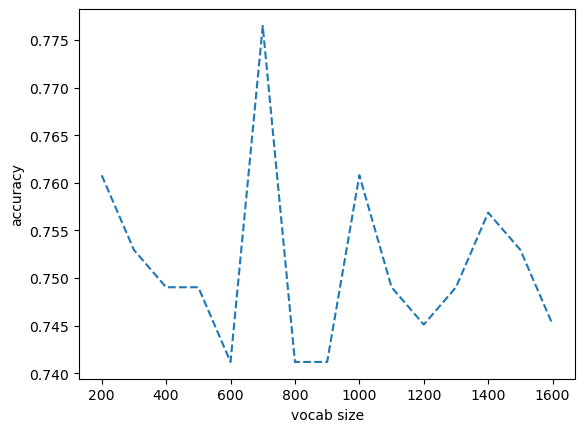

In [29]:
plt.plot(vocab_sizes, accuracies, ls='--')
plt.xlabel("vocab size")
plt.ylabel("accuracy")
plt.savefig("../images/vectorizer_max_features.svg");

In [29]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer = vectorizer.fit(X_train)

In [30]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [31]:
X_train.shape, X_test.shape

((2544, 700), (450, 700))

In [33]:
if SHOULD_SAVE:
    pickle.dump(vectorizer, open("../models/tfidf.sav", "wb"))

### StratifiedKFold split

In [34]:
skf = model_selection.StratifiedKFold(n_splits=10,
                                          shuffle=True,
                                          random_state=SEED)

models = [linear_model.LogisticRegression(random_state=SEED), 
          ensemble.RandomForestClassifier(random_state=SEED), 
          xgb.XGBClassifier(random_state=SEED),
          ensemble.AdaBoostClassifier(random_state=SEED),
          ensemble.GradientBoostingClassifier(random_state=SEED),
          lgb.LGBMClassifier(random_state=SEED)]

# model_result_dict = {model.__class__.__name__:[] for model in models}
acc_dict = defaultdict(list)

for fold, (tr, tt) in enumerate(skf.split(X_train, y_train)): 
   
    x_tr, x_tt = X_train[tr], X_train[tt]
    y_tr, y_tt = y_train[tr], y_train[tt]
    
    
    
    for model in models:
        model.fit(x_tr, y_tr)
        val_pred = model.predict(x_tt)
        acc_dict[model.__class__.__name__].append(metrics.accuracy_score(y_tt, val_pred))

In [35]:
skf_results = pd.DataFrame(acc_dict).T
skf_results.columns = [f"fold_{i}" for i in range(1, 11)]

In [36]:
skf_results["mean_acc"] = skf_results.iloc[:, :10].mean(axis=1)
skf_results["best_acc"] = skf_results.iloc[:, :10].max(axis=1)
skf_results["worst_acc"] = skf_results.iloc[:, :10].min(axis=1)
skf_results["std_acc"] = skf_results.iloc[:, :10].std(axis=1)

skf_results[["mean_acc", "std_acc"]].sort_values(by="mean_acc", ascending=False)

,mean_acc,std_acc
RandomForestClassifier,0.775552,0.018052
GradientBoostingClassifier,0.768467,0.016740
LGBMClassifier,0.754724,0.020520
XGBClassifier,0.751172,0.028113
AdaBoostClassifier,0.723678,0.025513
LogisticRegression,0.720094,0.023452


In [37]:
if SHOULD_SAVE:
    skf_results.to_csv("../results/skf_results_10.csv")

### Hyperparameter tuning

#### RandomSearch

In [59]:
param_dist = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : range(5, 21),
    "n_estimators" : range(100, 2001)
}

rand_cv = model_selection.RandomizedSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=SEED),
    param_distributions=param_dist,
    cv=model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="accuracy",
    random_state=SEED
)

rand_cv_start = time()

rand_cv.fit(X_train, y_train)

rand_cv_end = time()

print(f"Total time: {(rand_cv_end-rand_cv_start):.3f}")

Total time: 111.999


In [60]:
rand_cv.best_params_, rand_cv.best_score_

({'n_estimators': 1132, 'max_depth': 17, 'criterion': 'gini'},
 0.7865569357857773)

#### GridSearch

In [65]:
param_grid = {
    "max_depth" : range(16, 25),
    "n_estimators" : range(1100, 1351, 25)
}

grid_cv = model_selection.GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=SEED, criterion="gini"),
    param_grid = param_grid,
    cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="accuracy",
)

grid_cv_start = time()

grid_cv.fit(X_train, y_train)

grid_cv_end = time()

print(f"Total time: {(grid_cv_end-grid_cv_start):.3f}")

Total time: 1417.699


In [67]:
grid_cv.best_params_, grid_cv.best_score_

({'max_depth': 20, 'n_estimators': 1100}, 0.7869506365731789)

## Making Predictions

In [32]:
def macro_precision_score(y_true: np.ndarray,
                          y_pred: np.ndarray) -> float:
    
    y_true, y_pred = y_true.squeeze(), y_pred.squeeze()
    classes = np.unique(y_true)
    
    precisions = []
    for class_ in classes:
        true_pos = np.sum((y_true==class_) & (y_true==y_pred))
        pred_pos = np.sum(y_pred==class_)
        precisions.append(true_pos/pred_pos)
    
    return sum(precisions)/len(classes)

def plot_precision_recall_curve(y_true: np.ndarray,
                               y_proba: np.ndarray) -> Tuple[Dict[int, float]]:
    ohe = preprocessing.OneHotEncoder()
    y_true = ohe.fit_transform(y_true.reshape(-1, 1)).toarray()
    
    n_classes = y_true.shape[1]
    
    pr, re, pr_auc = dict(), dict(), dict()
    
    for i in range(n_classes):
        pr[i], re[i], _ = metrics.precision_recall_curve(y_true[:, i], y_proba[:, i])
        pr_auc[i] = metrics.average_precision_score(y_true[:, i], y_proba[:, i])
        plt.plot(re[i], pr[i], label=f"class-{list(classes.keys())[i]} (area={pr_auc[i]: .3f})")
    
    plt.legend()
    plt.xlabel("recall")
    plt.ylabel("precision")
    return pr, re, pr_auc
    
def plot_roc_auc_curve(y_true: np.ndarray,
                               y_proba: np.ndarray) -> Tuple[Dict[int, float]]:
    ohe = preprocessing.OneHotEncoder()
    y_true = ohe.fit_transform(y_true.reshape(-1, 1)).toarray()
    
    n_classes = y_true.shape[1]
    
    tpr, fpr, roc_auc = dict(), dict(), dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
        plt.plot(fpr[i], tpr[i], label=f"class-{list(classes.keys())[i]} (area={roc_auc[i]: .3f})")
    
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    return fpr, tpr, roc_auc
    
def evaluation_metrics(y_true: np.ndarray,
                      y_proba: np.ndarray) -> None:
    
    y_pred = np.argmax(y_proba, axis=1).squeeze()
    y_true = y_true.squeeze()
    
    acc = metrics.accuracy_score(y_true, y_pred)
    print(f"Accuracy score: {(acc*100):.1f}%")
    print("\n")
    print("="*100)
    print("Classification report")
    print("\n")
    print(metrics.classification_report(y_true, y_pred))
    print("="*100)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    _, _, _ = plot_precision_recall_curve(y_true, y_proba)
    plt.subplot(122)
    _, _, _ = plot_roc_auc_curve(y_true, y_proba)

Accuracy score: 77.6%


Classification report


              precision    recall  f1-score   support

           0       0.66      0.98      0.79       182
           1       0.94      0.84      0.88       142
           2       0.96      0.40      0.57       126

    accuracy                           0.78       450
   macro avg       0.85      0.74      0.75       450
weighted avg       0.83      0.78      0.76       450



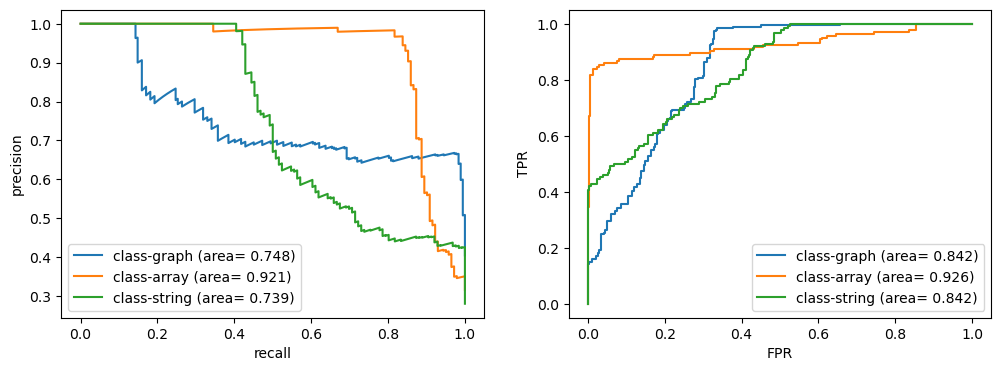

In [39]:
model = ensemble.RandomForestClassifier(max_depth=20,
                                       n_estimators=1100,
                                       random_state=SEED)
model = model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)

evaluation_metrics(y_test, y_proba)

In [40]:
prs, res, pr_aucs = [], [], []

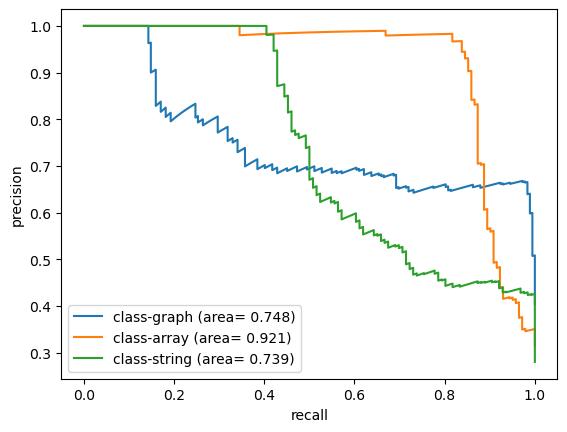

In [41]:
pr, re, pr_auc = plot_precision_recall_curve(y_test, y_proba)
pr = (pr[0] + pr[1] + pr[2])/3
re = (re[0] + re[1] + re[2])/3
pr_auc = (pr_auc[0] + pr_auc[1] + pr_auc[2])/3

prs.append(pr)
res.append(re)
pr_aucs.append(pr_auc)

In [42]:
if SHOULD_SAVE:
    pickle.dump(model, file=open("../models/rfc.sav", "wb"))

## Creating more models

### GradientBoosting

#### Random Search

In [38]:
param_distributions = {
    "learning_rate" : np.arange(0.1, 1.1, 0.01),
    "max_depth" : range(10, 31),
    "n_estimators" : range(200, 1501)
}

rand_cv = model_selection.RandomizedSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=SEED),
    param_distributions=param_distributions,
    cv=model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="accuracy",
    random_state=SEED
)

start_time = time()

rand_cv.fit(X_train, y_train)

end_time = time()

print(f"Total time: {end_time-start_time}")
print(f"Best parameters: {rand_cv.best_params_}")
print(f"Best score: {rand_cv.best_score_}")

Total time: 4638.179350852966
Best parameters: {'n_estimators': 1019, 'max_depth': 26, 'learning_rate': 0.8199999999999996}
Best score: 0.762571353433473


Accuracy score: 76.0%


Classification report


              precision    recall  f1-score   support

           0       0.66      0.88      0.75       182
           1       0.98      0.84      0.90       142
           2       0.73      0.50      0.59       126

    accuracy                           0.76       450
   macro avg       0.79      0.74      0.75       450
weighted avg       0.78      0.76      0.76       450



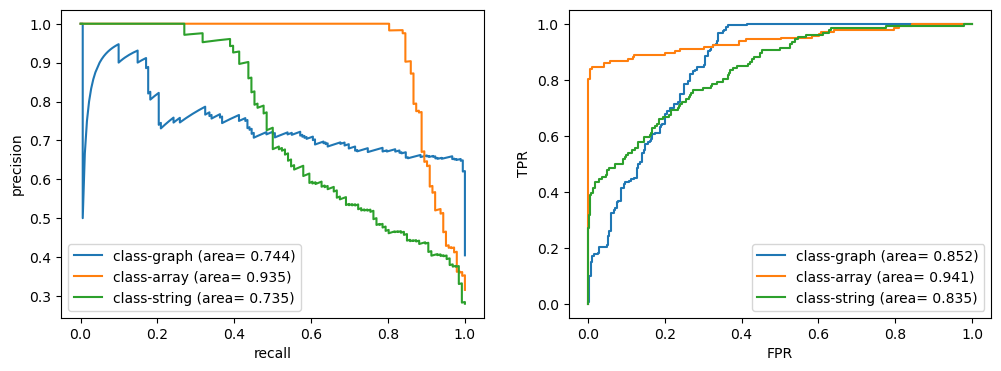

In [43]:
gb_model = ensemble.GradientBoostingClassifier(
    n_estimators = 1019,
    max_depth = 26,
    learning_rate = 0.82,
    random_state=SEED
)

gb_model = gb_model.fit(X_train, y_train)
y_proba = gb_model.predict_proba(X_test)
evaluation_metrics(y_test, y_proba)

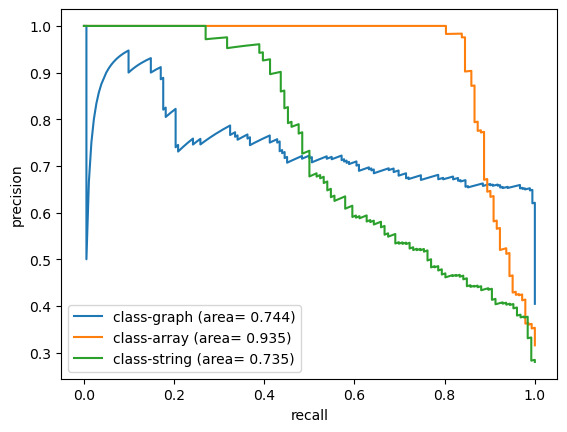

In [44]:
pr, re, pr_auc = plot_precision_recall_curve(y_test, y_proba)
pr = (pr[0] + pr[1] + pr[2])/3
re = (re[0] + re[1] + re[2])/3
pr_auc = (pr_auc[0] + pr_auc[1] + pr_auc[2])/3

prs.append(pr)
res.append(re)
pr_aucs.append(pr_auc)

In [45]:
if SHOULD_SAVE:
    pickle.dump(gb_model, open("../models/gb.sav", "wb"))

### XGBoost

#### Random Search

In [40]:
param_distributions = {
    "learning_rate" : np.arange(0.1, 1.1, 0.01),
    "max_depth" : range(10, 31),
    "n_estimators" : range(200, 1501)
}

rand_cv = model_selection.RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=SEED),
    param_distributions=param_distributions,
    cv=model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="accuracy",
    random_state=SEED
)

start_time = time()

rand_cv.fit(X_train, y_train)

end_time = time()

print(f"Total time: {end_time-start_time}")
print(f"Best parameters: {rand_cv.best_params_}")
print(f"Best score: {rand_cv.best_score_}")

Total time: 122.05909085273743
Best parameters: {'n_estimators': 619, 'max_depth': 20, 'learning_rate': 0.3299999999999999}
Best score: 0.7543214269139736


Accuracy score: 74.9%


Classification report


              precision    recall  f1-score   support

           0       0.65      0.87      0.75       182
           1       0.96      0.84      0.89       142
           2       0.72      0.47      0.57       126

    accuracy                           0.75       450
   macro avg       0.78      0.73      0.74       450
weighted avg       0.77      0.75      0.74       450



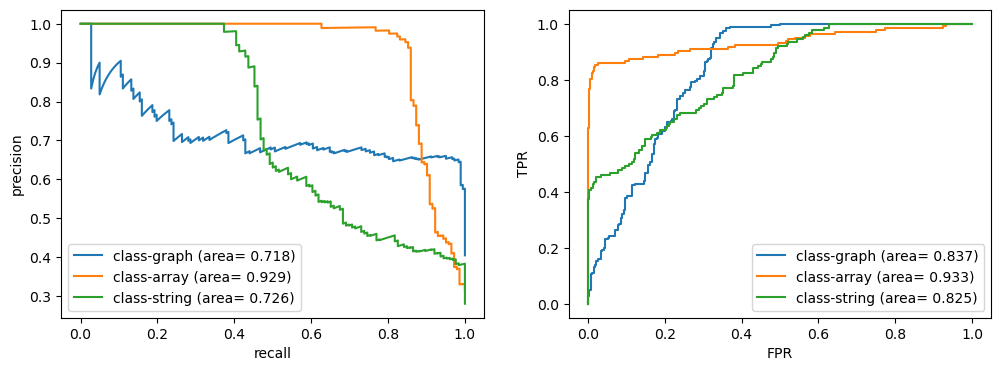

In [46]:
xgb_model = xgb.XGBClassifier(
    random_state=SEED,
    n_estimators=619,
    max_depth=20,
    learning_rate=0.33
)
xgb_model = xgb_model.fit(X_train, y_train)
y_proba = xgb_model.predict_proba(X_test)
evaluation_metrics(y_test, y_proba)

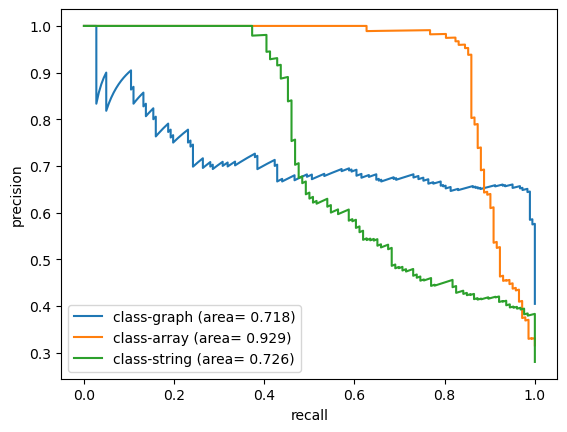

In [47]:
pr, re, pr_auc = plot_precision_recall_curve(y_test, y_proba)
pr = (pr[0][:450] + pr[1][:450] + pr[2][:450])/3
re = (re[0][:450] + re[1][:450] + re[2][:450])/3
pr_auc = (pr_auc[0] + pr_auc[1] + pr_auc[2])/3

prs.append(pr)
res.append(re)
pr_aucs.append(pr_auc)

In [48]:
if SHOULD_SAVE:
    pickle.dump(xgb_model, open("../models/xgb.sav", "wb"))

### LGBMClassifer

#### Random Search

In [42]:
param_distributions = {
    "learning_rate" : np.arange(0.1, 1.1, 0.01),
    "max_depth" : range(10, 31),
    "n_estimators" : range(200, 1501)
}

rand_cv = model_selection.RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=SEED),
    param_distributions=param_distributions,
    cv=model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="accuracy",
    random_state=SEED
)

start_time = time()

rand_cv.fit(X_train, y_train)

end_time = time()

print(f"Total time: {end_time-start_time}")
print(f"Best parameters: {rand_cv.best_params_}")
print(f"Best score: {rand_cv.best_score_}")

Total time: 143.8557300567627
Best parameters: {'n_estimators': 809, 'max_depth': 13, 'learning_rate': 0.23999999999999994}
Best score: 0.7578662809584952


Accuracy score: 76.4%


Classification report


              precision    recall  f1-score   support

           0       0.66      0.90      0.76       182
           1       0.97      0.85      0.90       142
           2       0.77      0.48      0.60       126

    accuracy                           0.76       450
   macro avg       0.80      0.74      0.75       450
weighted avg       0.79      0.76      0.76       450



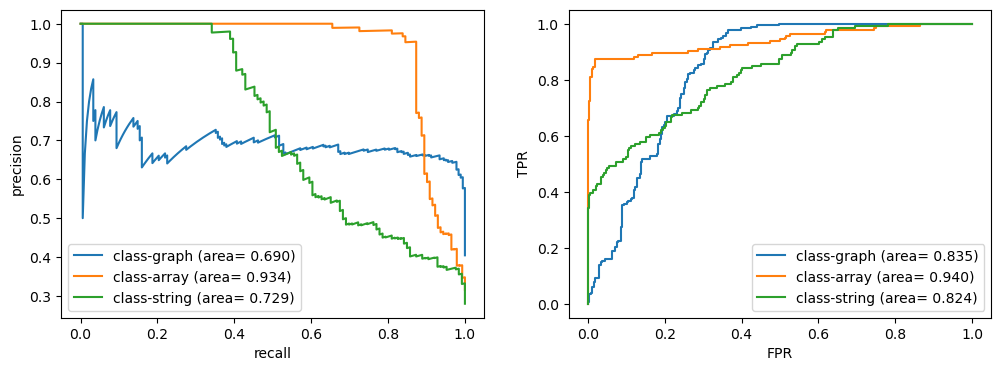

In [49]:
lgb_model = lgb.LGBMClassifier(
    random_state=SEED,
    n_estimators=809,
    max_depth=13,
    learning_rate=0.24
)
lgb_model = lgb_model.fit(X_train, y_train)
y_proba = lgb_model.predict_proba(X_test)
evaluation_metrics(y_test, y_proba)

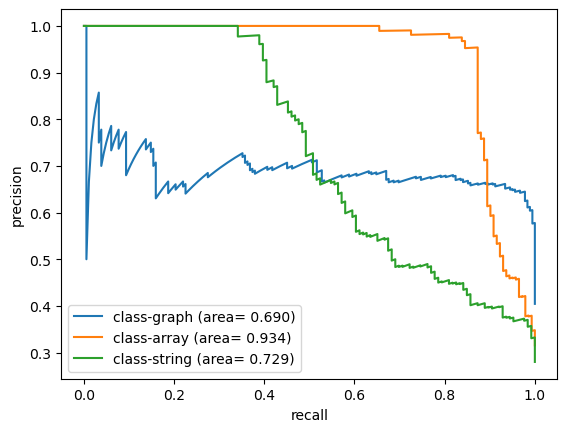

In [50]:
pr, re, pr_auc = plot_precision_recall_curve(y_test, y_proba)
pr = (pr[0][:450] + pr[1][:450] + pr[2][:450])/3
re = (re[0][:450] + re[1][:450] + re[2][:450])/3
pr_auc = (pr_auc[0] + pr_auc[1] + pr_auc[2])/3

prs.append(pr)
res.append(re)
pr_aucs.append(pr_auc)

In [51]:
if SHOULD_SAVE:
    pickle.dump(lgb_model, open("../models/lgb.sav", "wb"))

## Ensemble models

### Stacking

**Layer 1** -> `Random Forest`, `Gradient Boosting`, `XGBoost`, `LGB` <br>
**Layer 2** -> `Logisitc Regression`

Accuracy score: 77.8%


Classification report


              precision    recall  f1-score   support

           0       0.66      0.97      0.79       182
           1       0.96      0.84      0.89       142
           2       0.92      0.44      0.59       126

    accuracy                           0.78       450
   macro avg       0.85      0.75      0.76       450
weighted avg       0.83      0.78      0.77       450



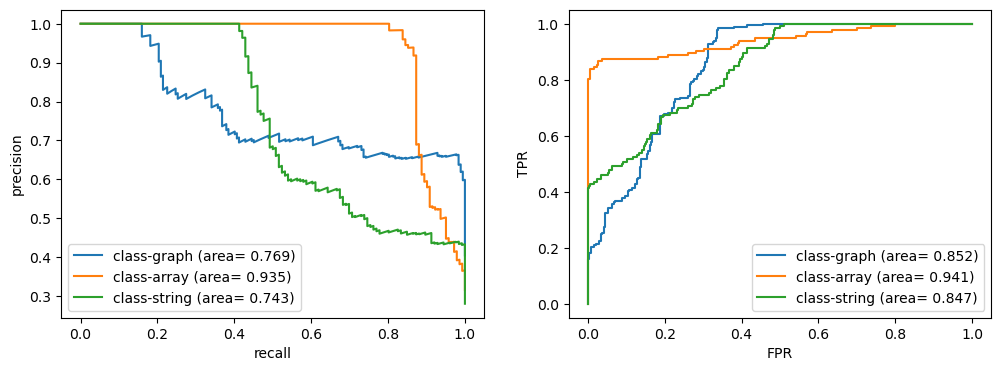

In [33]:
rfc_model = base.clone(pickle.load(open("../models/rfc.sav", "rb")))
gb_model  = base.clone(pickle.load(open("../models/gb.sav", "rb")))
xgb_model = base.clone(pickle.load(open("../models/xgb.sav", "rb")))
lgb_model = base.clone(pickle.load(open("../models/lgb.sav", "rb")))

lr = linear_model.LogisticRegression(random_state=SEED)
stck_clf = ensemble.StackingClassifier(estimators=[('rfc', rfc_model), ('gb', gb_model), ('xgb', xgb_model), ('lgb', lgb_model)],
                                      final_estimator=lr,
                                      cv=model_selection.StratifiedKFold(n_splits=5,
                                                                        shuffle=True,
                                                                        random_state=SEED))
stck_clf.fit(X_train, y_train)
y_proba = stck_clf.predict_proba(X_test)
evaluation_metrics(y_test, y_proba)

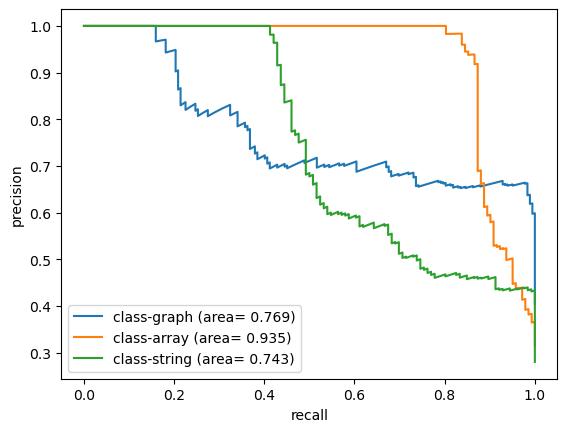

In [53]:
pr, re, pr_auc = plot_precision_recall_curve(y_test, y_proba)
pr = (pr[0][:450] + pr[1][:450] + pr[2][:450])/3
re = (re[0][:450] + re[1][:450] + re[2][:450])/3
pr_auc = (pr_auc[0] + pr_auc[1] + pr_auc[2])/3

prs.append(pr)
res.append(re)
pr_aucs.append(pr_auc)

In [34]:
# if SHOULD_SAVE:
pickle.dump(stck_clf, open("../models/stacked_tagger.sav", "wb"))

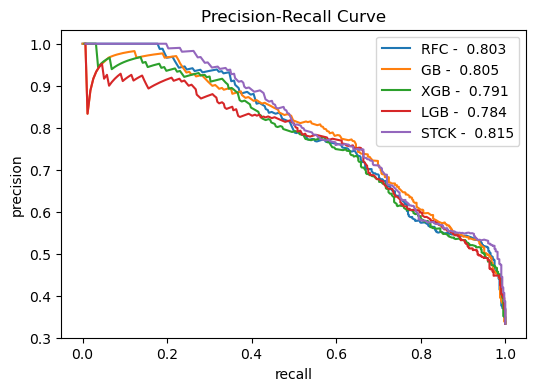

In [55]:
models = ["RFC", "GB", "XGB", "LGB", "STCK"]

plt.figure(figsize=(6, 4))
for i, (pr, re, pr_auc) in enumerate(zip(prs, res, pr_aucs)):
    plt.plot(re, pr, label=f"{models[i]} - {pr_auc: .3f}")
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig("../images//precision_recall_curve.svg");